# Game of Life

In [16]:
import numpy as np
def gol_update(X):
    """Game of life step using scipy tools"""
    from scipy.signal import convolve2d
    nbrs_count = convolve2d(X, np.ones((3, 3)), mode='same', boundary='fill') - X
    return (nbrs_count == 3) | (X & (nbrs_count == 2))

def make_move(field, moves=1):
    """
    Make a move forward according to Game of Life rules
    """
    for i in range(moves):
      field=gol_update(field)
    return field

# Genetic Algorithm 

In [17]:
def generate_population(size,r=5,c=5, random_state=-1):
    """
    Generating initial population of individual solutions
    :return: initial population as a list of set dimension arrays
    """
    if random_state != -1:
        np.random.seed(random_state)
    initial_states = np.split(np.random.binomial(1, 0.5, (r * size, c)).astype('uint8'), size)
    return initial_states

In [18]:
def fitness(start_field, end_field, delta):
    """
    Calculate fitness for particular candidate (start configuration of the field)
    :param start_field: candidate (start configuration)
    :param end_field: target (stop configuration)
    :param delta: number of steps to proceed before comparing to stop configuration
    :return: value in range [0, 1] that indicates fractions of cells that match their state
    """
    candidate = make_move(start_field, moves=delta)
    return (candidate == end_field).sum() / len(end_field)/len(end_field[0])

def score_population(population, target, delta):
    """
    Apply fitness function for each gene in a population
    :param population: list of candidate solutions
    :param target: 10x10 array that represents field in stopping condition
    :param delta: number of steps to revert
    :return: list of scores for each solution
    """
    return [fitness(gene, target, delta) for gene in population]

In [19]:
def selection(population, scores, retain_frac=0.85, retain_random=0.05):
    """
    Apply selection operator to the population
    """
    retain_len = int(len(scores) * retain_frac)
    sorted_indices = np.argsort(scores)[::-1]
    population = [population[idx] for idx in sorted_indices]
    selected = population[:retain_len]
    leftovers = population[retain_len:]
    
    for gene in leftovers:
        if np.random.rand() < retain_random:
            selected.append(gene)     
    return selected

In [20]:
def mutate(field, switch_frac=1):
    """ Inplace mutation of the provided field """
    a = np.random.binomial(1, switch_frac, size=(len(field), len(field[0]))).astype('bool')
    field[a] += 1
    field[a] %= 2
    return field

In [21]:
def crossover(mom, dad):
    """ Take two parents, return two children, interchanging half of the allels of each parent randomly """
    select_mask = np.random.binomial(1, 0.5, size=(len(mom), len(mom[0]))).astype('bool')
    child1, child2 = np.copy(mom), np.copy(dad)
    child1[select_mask] = dad[select_mask]
    child2[select_mask] = mom[select_mask]
    return child1, child2

In [22]:
def evolve(population, target, delta, retain_frac=0.75, retain_random=0.05, mutate_chance=0.05,mutate_switch_frac=1,immigrants=0):
    """
    Evolution step
    """
    scores = score_population(population, target, delta)
    next_population = selection(population, scores, retain_frac=retain_frac, retain_random=retain_random)
    
    # mutate everyone expecting for the best candidate
    for gene in next_population[1:]:
        if np.random.rand() < mutate_chance:
            mutate(gene,mutate_switch_frac)
 
    places_left = len(population) - len(next_population)
    children = []
    parent_max_idx = len(next_population) - 1
    while len(children) < places_left:
        mom_idx, dad_idx = np.random.randint(0, parent_max_idx, 2)
        if mom_idx != dad_idx:
            child1, child2 = crossover(next_population[mom_idx], next_population[dad_idx])
            children.append(child1)
            if len(children) < places_left:
                children.append(child2)
    next_population.extend(children)

    if immigrants>0:
        next_population.extend(generate_population(int(immigrants*len(scores)),r=len(target),c=len(target[0])))   
    return next_population

In [23]:
def solve(target, delta,population_size=300, n_generations=700,random_state=-1):
   
    fitnessList=[]
    bestPatternList=[]

    # initialize population
    population = generate_population(population_size,r=len(target),c=len(target[0]),random_state=random_state)
    
    # evolution
    for generation in range(n_generations):
        population = evolve(population, target, delta,mutate_chance=0.05,mutate_switch_frac=0.9)
        
        fitnessList.append(fitness(population[0], target, delta))
        bestPatternList.append(population[0])

        print("Generation ", generation, ", final best score: ", fitness(population[0], target, delta))
    return (bestPatternList,fitnessList)

# Visusal Display

In [24]:
import matplotlib.pyplot as plt
from matplotlib import colors
def display_pattern(X,dpi=5):
    # figure config
    figsize = (len(X) * 5. / dpi, len(X[0]) * 5. / dpi)
    cmap = colors.ListedColormap(['white', 'black'])
    fig, ax = plt.subplots(figsize=figsize)
    im=ax.imshow(X, cmap=cmap)
    
    #set x and y ticks and labels
    plt.xticks(range(len(X[0])), range(len(X[0])))
    plt.yticks(range(len(X)), range(len(X)-1,-1,-1));
 
    #set minor axes in between the labels
    ax=plt.gca()
    ax.set_xticks([x-0.5 for x in range(1,len(X[0]))],minor=True )
    ax.set_yticks([y-0.5 for y in range(1,len(X))],minor=True)
    #plot grid on minor axes
    plt.grid(which="minor",ls="-",lw=2)
    return ax

In [32]:
from matplotlib import animation
from matplotlib import colors
import matplotlib.pyplot as plt
from IPython.display import HTML
X = np.asarray(Xs[0])
X = X.astype(bool)
X_blank = np.zeros_like(X)
    
    # figure config
figsize = (X.shape[0] * 5. / dpi, X.shape[1] * 5. / dpi)
cmap = colors.ListedColormap(['white', 'black'])
fig, ax = plt.subplots(figsize=figsize)
im=ax.imshow(X, cmap=cmap)
    
    #set x and y ticks and labels
plt.xticks(range(X.shape[1]), range(X.shape[1]))
plt.yticks(range(X.shape[0]), range(X.shape[0]-1,-1,-1));
 
    #set minor axes in between the labels
ax=plt.gca()
ax.set_xticks([x-0.5 for x in range(1,X.shape[1])],minor=True )
ax.set_yticks([y-0.5 for y in range(1,X.shape[0])],minor=True)
ax.set_title("generation "+str(gens[0]))
    #plot grid on minor axes
plt.grid(which="minor",ls="-",lw=2)
 
    # initialization function: plot the background of each frame
def init():
    im.set_data(X_blank)
 
    # animation function.  This is called sequentially
def animate(i):
    im.set_data(make_move(animate.Xs[i], moves=delta))
    ax.set_title("generation "+str(gens[i]))
    animate.X = Xs[i]
    
animate.Xs = Xs
return animation.FuncAnimation(fig, animate, init_func=init,frames=frames, interval=interval)

NameError: name 'Xs' is not defined

In [33]:
def disp_target_result(target,result,delta,animate=0):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(5, 5))
    fig.tight_layout()
    X=target
    ax[0].set_xticks(range(len(X[0])), range(len(X[0])))
    ax[0].set_yticks(range(len(X)), range(len(X)-1,-1,-1))
    ax[ 1].set_xticks(range(len(X[0])), range(len(X[0])))
    ax[1].set_yticks(range(len(X)), range(len(X)-1,-1,-1))
    ax[0].imshow(target, cmap=plt.cm.Greys)
    ax[ 0].set_title("Target end field")
    ax[1].imshow(make_move(result, moves=delta), cmap=plt.cm.Greys)
    ax[ 1].set_title("GA solution end field\nfitness="+"{:.2f}".format(fitness(result, target, delta)))
 

Generation  0 , final best score:  0.61
Generation  1 , final best score:  0.61
Generation  2 , final best score:  0.61
Generation  3 , final best score:  0.61
Generation  4 , final best score:  0.61
Generation  5 , final best score:  0.63
Generation  6 , final best score:  0.63
Generation  7 , final best score:  0.63
Generation  8 , final best score:  0.65
Generation  9 , final best score:  0.65
Generation  10 , final best score:  0.6599999999999999
Generation  11 , final best score:  0.6900000000000001
Generation  12 , final best score:  0.6900000000000001
Generation  13 , final best score:  0.7
Generation  14 , final best score:  0.7
Generation  15 , final best score:  0.7
Generation  16 , final best score:  0.71
Generation  17 , final best score:  0.71
Generation  18 , final best score:  0.71
Generation  19 , final best score:  0.71
Generation  20 , final best score:  0.73
Generation  21 , final best score:  0.74
Generation  22 , final best score:  0.75
Generation  23 , final best 

Text(0.5, 1.0, 'result')

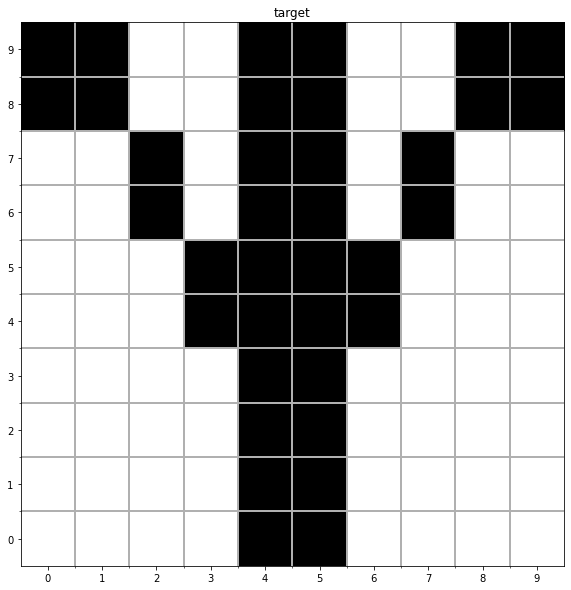

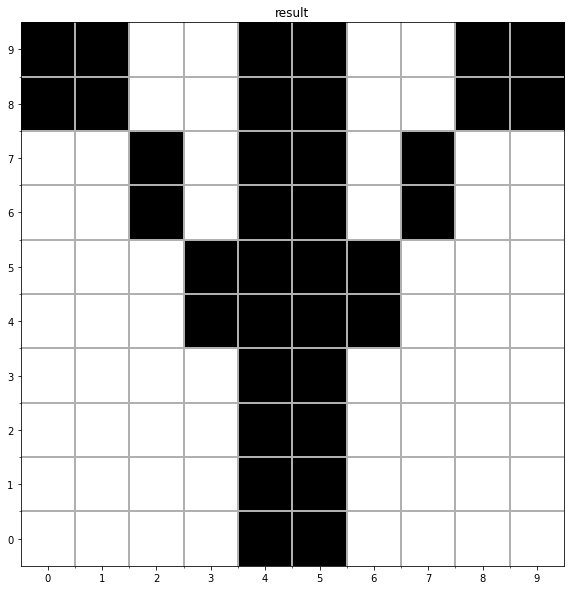

In [34]:
target= [
    [1,1,0,0,1,1,0,0,1,1],
    [1,1,0,0,1,1,0,0,1,1],
    [0,0,1,0,1,1,0,1,0,0],
    [0,0,1,0,1,1,0,1,0,0],
    [0,0,0,1,1,1,1,0,0,0],
    [0,0,0,1,1,1,1,0,0,0],
    [0,0,0,0,1,1,0,0,0,0],
    [0,0,0,0,1,1,0,0,0,0],
    [0,0,0,0,1,1,0,0,0,0],
    [0,0,0,0,1,1,0,0,0,0],
]
delta=0
# target=make_move(target,20)

ax=display_pattern(target)
ax.set_title("target")

result = solve(target, delta=delta, 
                  population_size=100,n_generations=3000,
                   random_state=1)

ax=display_pattern(make_move(result[0][-1],delta))
ax.set_title("result")


<ipython-input-33-236c942b51e4>:5: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_xticks(range(len(X[0])), range(len(X[0])))
<ipython-input-33-236c942b51e4>:6: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_yticks(range(len(X)), range(len(X)-1,-1,-1))
<ipython-input-33-236c942b51e4>:7: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[ 1].set_xticks(range(len(X[0])), range(len(X[0])))
<ipython-input-33-236c942b51e4>:8: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the p

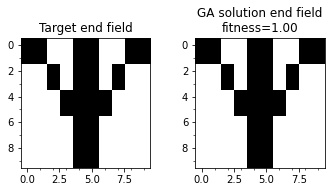

In [36]:
# compare "target" vs "the best match after delta updates"
disp_target_result(target,result[0][-1],delta)